In [1]:
import random
import matplotlib.pyplot as plt

In [2]:
random.seed(1)

In [3]:
habitable_width, habitable_length = 100, 100

In [4]:
class Location:
    def __init__ (self, x, y):
        self.x = x
        self.y = y
    def __eq__ (self, other):
        return (self.x == other.x) and (self.y == other.y)
    def __hash__ (self):
        return hash((self.x, self.y))

In [5]:
def random_house_location():
    #naming the side on x-axis '1' and the following sides similarly in clockwise direction
    chosen_side = random.randint(1, 4)
    match chosen_side:
        case 1:
            return Location(x = random.randrange(0, habitable_length), y = 0)
        case 2:
            return Location(x = habitable_length, y = random.randrange(1, habitable_width))
        case 3:
            return Location(x = random.randrange(0, habitable_length - 1), y = habitable_width)
        case 4:
            return Location(x = 0, y = random.randrange(1, habitable_width - 1))

In [6]:
class Organism:
    def __init__ (self, location, health, energy, mass, energy_required_to_survive, surplus_energy_to_reproduce):
        self.health = health
        self.energy = energy
        self.mass = mass
        self.location = location
        self.energy_required_to_survive = energy_required_to_survive #current amount of energy required, if excess by an amount delta than reproduce
        self.surplus_energy_to_reproduce = surplus_energy_to_reproduce # if energy surplus == this amount, then reproduce
    def isAlive(self):
        return self.health > 0

In [7]:
class Food:
    def __init__ (self, location, energy):
        self.energy = energy
        self.location = location

In [8]:
def airdrop_food(food_quantity):
    food_data = [Food(energy = random.randrange(10, 20), location = Location(random.randrange(2, habitable_length - 1), random.randrange(2, habitable_width - 1))) for _ in range(food_quantity)]
    food_map = {food.location : food for food in food_data}
    return food_map

In [9]:
class Simple_organism(Organism):
    def __init__ (self, location, health = 1, energy = 5, mass = 1, energy_required_to_survive = 10, surplus_energy_to_reproduce = 10):
        super().__init__(location, health, energy, mass, energy_required_to_survive, surplus_energy_to_reproduce)

In [10]:
food_airdropped_per_day = 100

In [11]:
total_fauna = 100
fauna = [Simple_organism(location = random_house_location()) for _ in range(total_fauna)] # organism spawned
fauna_alive = total_fauna
fauna_alive_history = [fauna_alive]
for day in range(100):
    print(f"Day ................................... {day}")
    food_map = airdrop_food(food_airdropped_per_day)
    for being in fauna:
        if being.isAlive():
            being.location = Location(random.randrange(2, habitable_length - 1), random.randrange(2, habitable_width - 1))
            if being.location in food_map:
                #being succeeds to find food
                being.energy += food_map[being.location].energy
                del food_map[being.location]
            if being.energy >= being.energy_required_to_survive:
                # being survives
                being.health = 1
                being.energy -= being.energy_required_to_survive
                if being.energy >= being.surplus_energy_to_reproduce:
                    #being reproduces
                    fauna.append(Simple_organism(location = random_house_location()))
                    fauna_alive += 1
                    being.energy -= being.surplus_energy_to_reproduce
                #being is still alive, therefore, it goes back to the village
                being.location = random_house_location()
            else:
                #being dies
                being.health = 0
                fauna_alive -= 1
    fauna_alive_history.append(fauna_alive)

Day ................................... 0
Day ................................... 1
Day ................................... 2
Day ................................... 3
Day ................................... 4
Day ................................... 5
Day ................................... 6
Day ................................... 7
Day ................................... 8
Day ................................... 9
Day ................................... 10
Day ................................... 11
Day ................................... 12
Day ................................... 13
Day ................................... 14
Day ................................... 15
Day ................................... 16
Day ................................... 17
Day ................................... 18
Day ................................... 19
Day ................................... 20
Day ................................... 21
Day ................................... 22
Day .................

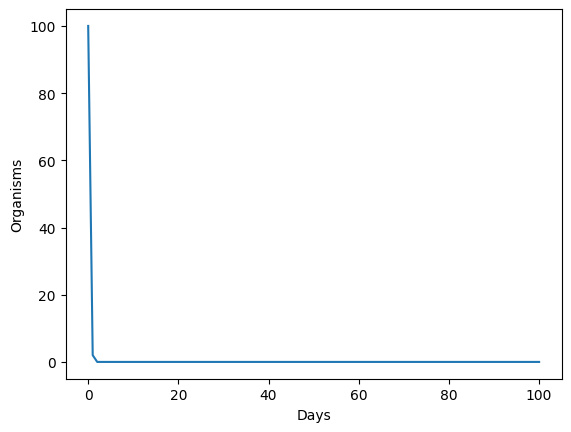

In [12]:
plt.plot(fauna_alive_history, label = "History")
plt.xlabel('Days')
plt.ylabel('Organisms')
plt.show()